Khởi tạo datasets

In [25]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import random

def augment_hsv(im, hgain= 0, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


# Change cv2.resize to import data correctly

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, width, height):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        self.width, self.height = width, height

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index])
        image = cv2.resize(image, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
        augment_hsv(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0 ## (512, 512, 3)
        
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        
        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
        # mask = mask/255.0   ## (512, 512)
        mask = cv2.resize(mask, (160, 80), interpolation=cv2.INTER_LINEAR)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        
        mask = np.where(mask != 0, 1.0, 0.0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask
    def __len__(self):
        return self.n_samples
    

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



Khởi tạo hàm loss và hàm tính mIoU

In [23]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F



class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
    

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold = 0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = torch.sigmoid(outputs)
    outputs = (outputs> threshold)
    outputs = outputs.to(dtype=torch.int8)

    labels = labels.to(dtype=torch.int8)
    # print(outputs)
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # print(iou/outputs.shape[0])
    return sum(iou)/outputs.shape[0]  # Or thresholded.mean() if you are interested in average across the batch



Khởi tạo mô hình Unet

In [24]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        #self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, group=out_c)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


Dataset Size:
Train: 50 - Valid: 50

Epoch: 1
Train...


100%|██████████| 13/13 [00:01<00:00, 12.99it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.16it/s]


Mean IoU: 0.1662
Valid loss improved from inf to 1.1755. Saving checkpoint: ./best.pth
	Train Loss: 0.865
	 Val. Loss: 1.176



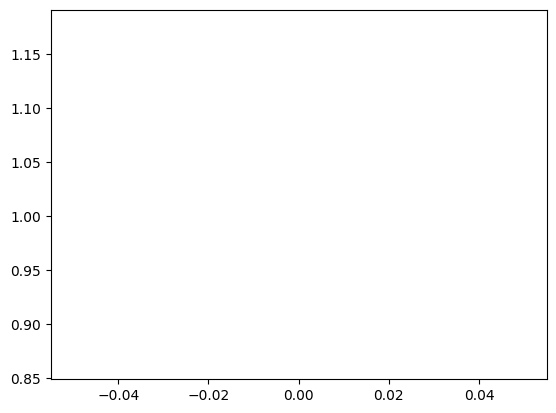

Epoch: 2
Train...


100%|██████████| 13/13 [00:00<00:00, 14.31it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.92it/s]


Mean IoU: 0.6331
Valid loss improved from 1.1755 to 0.8601. Saving checkpoint: ./best.pth
	Train Loss: 0.530
	 Val. Loss: 0.860



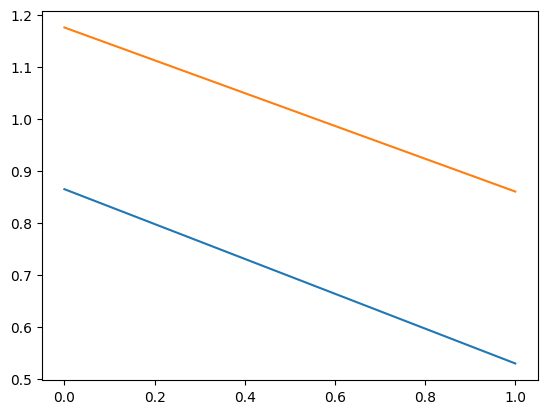

Epoch: 3
Train...


100%|██████████| 13/13 [00:00<00:00, 14.39it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.49it/s]


Mean IoU: 0.4924
Valid loss improved from 0.8601 to 0.7247. Saving checkpoint: ./best.pth
	Train Loss: 0.443
	 Val. Loss: 0.725



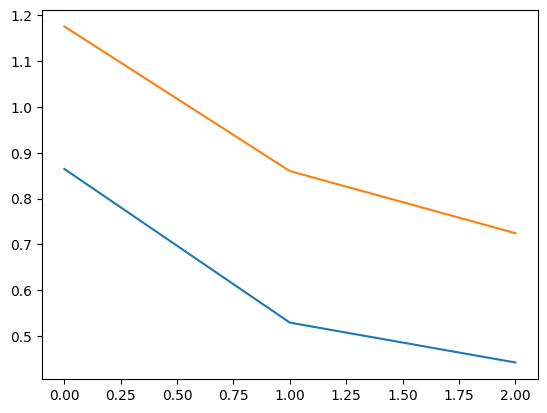

Epoch: 4
Train...


100%|██████████| 13/13 [00:00<00:00, 14.40it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.16it/s]


Mean IoU: 0.5116
Valid loss improved from 0.7247 to 0.6205. Saving checkpoint: ./best.pth
	Train Loss: 0.407
	 Val. Loss: 0.621



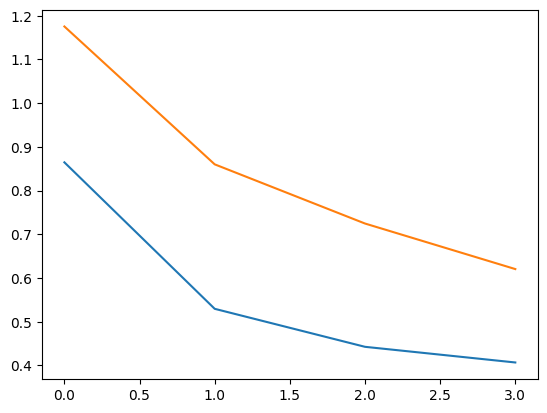

Epoch: 5
Train...


100%|██████████| 13/13 [00:00<00:00, 14.39it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.85it/s]


Mean IoU: 0.6070
Valid loss improved from 0.6205 to 0.4186. Saving checkpoint: ./best.pth
	Train Loss: 0.395
	 Val. Loss: 0.419



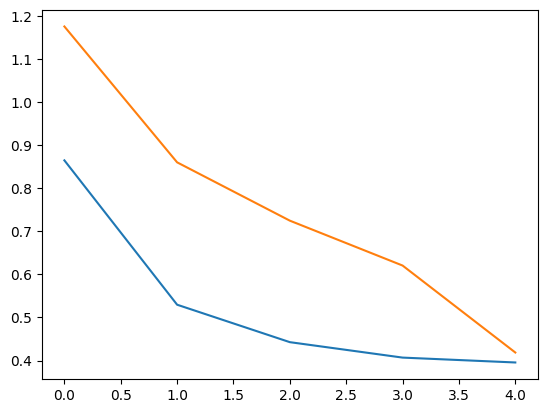

Epoch: 6
Train...


100%|██████████| 13/13 [00:00<00:00, 14.27it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.53it/s]


Mean IoU: 0.6039
Valid loss improved from 0.4186 to 0.3728. Saving checkpoint: ./best.pth
	Train Loss: 0.354
	 Val. Loss: 0.373



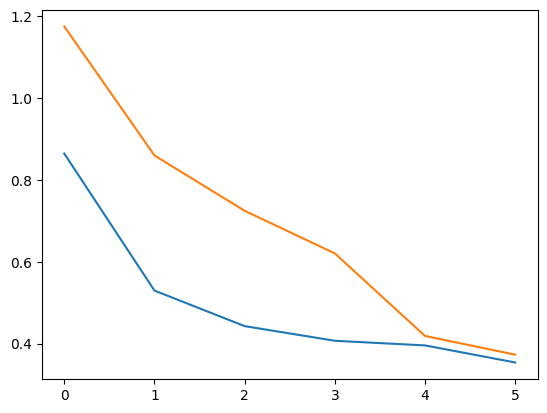

Epoch: 7
Train...


100%|██████████| 13/13 [00:00<00:00, 14.24it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.22it/s]


Mean IoU: 0.6061
Valid loss improved from 0.3728 to 0.3631. Saving checkpoint: ./best.pth
	Train Loss: 0.336
	 Val. Loss: 0.363



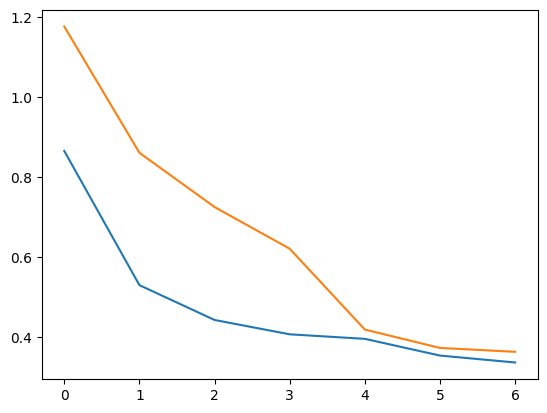

Epoch: 8
Train...


100%|██████████| 13/13 [00:00<00:00, 14.32it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.01it/s]


Mean IoU: 0.6064
Valid loss improved from 0.3631 to 0.3554. Saving checkpoint: ./best.pth
	Train Loss: 0.322
	 Val. Loss: 0.355



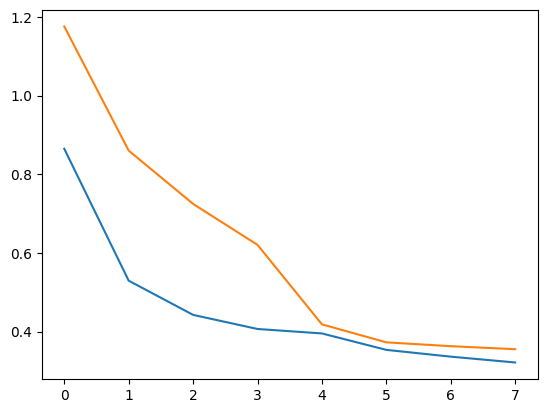

Epoch: 9
Train...


100%|██████████| 13/13 [00:00<00:00, 14.29it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 43.70it/s]


Mean IoU: 0.6151
Valid loss improved from 0.3554 to 0.3407. Saving checkpoint: ./best.pth
	Train Loss: 0.316
	 Val. Loss: 0.341



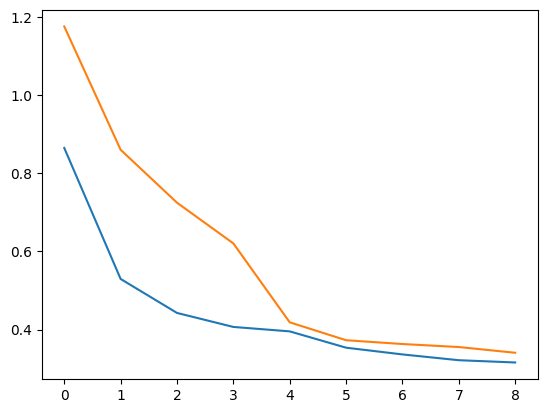

Epoch: 10
Train...


100%|██████████| 13/13 [00:00<00:00, 14.31it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.13it/s]


Mean IoU: 0.5922
	Train Loss: 0.303
	 Val. Loss: 0.372



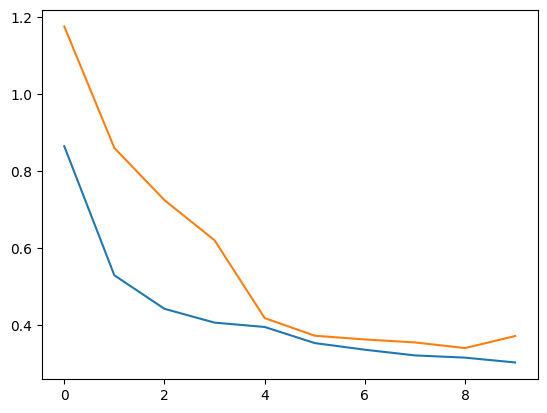

Epoch: 11
Train...


100%|██████████| 13/13 [00:00<00:00, 14.25it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.15it/s]


Mean IoU: 0.5960
Valid loss improved from 0.3407 to 0.3194. Saving checkpoint: ./best.pth
	Train Loss: 0.292
	 Val. Loss: 0.319



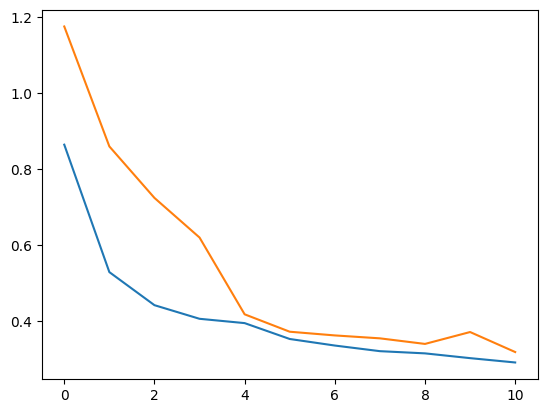

Epoch: 12
Train...


100%|██████████| 13/13 [00:00<00:00, 14.24it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.54it/s]


Mean IoU: 0.6121
	Train Loss: 0.293
	 Val. Loss: 0.404



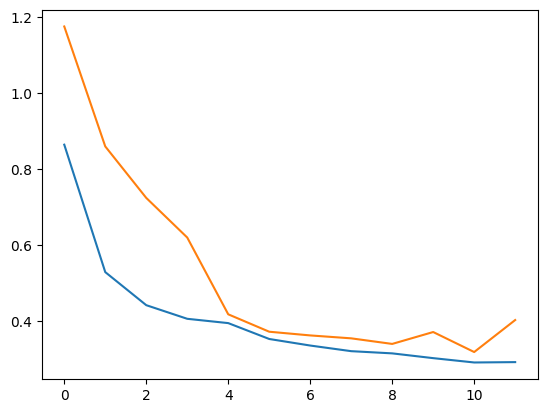

Epoch: 13
Train...


100%|██████████| 13/13 [00:00<00:00, 14.16it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.20it/s]


Mean IoU: 0.6096
Valid loss improved from 0.3194 to 0.2987. Saving checkpoint: ./best.pth
	Train Loss: 0.287
	 Val. Loss: 0.299



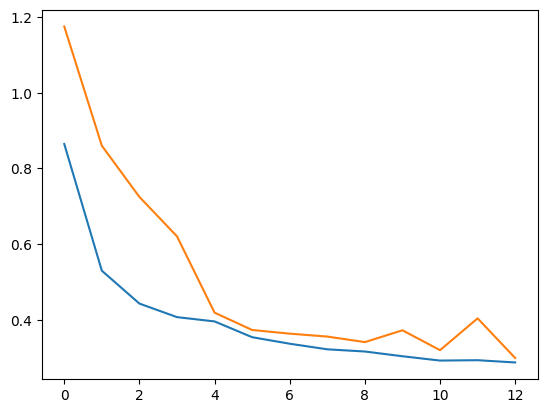

Epoch: 14
Train...


100%|██████████| 13/13 [00:00<00:00, 14.22it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.06it/s]


Mean IoU: 0.6041
	Train Loss: 0.276
	 Val. Loss: 0.321



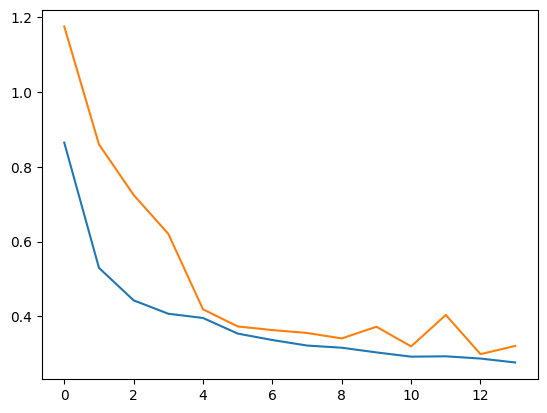

Epoch: 15
Train...


100%|██████████| 13/13 [00:00<00:00, 14.20it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.23it/s]


Mean IoU: 0.6060
	Train Loss: 0.257
	 Val. Loss: 0.315



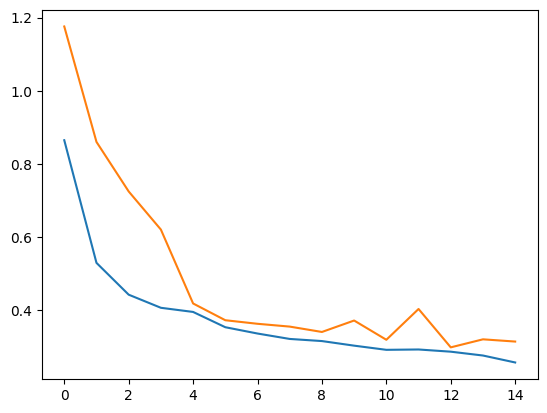

Epoch: 16
Train...


100%|██████████| 13/13 [00:00<00:00, 14.19it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.14it/s]


Mean IoU: 0.6088
Valid loss improved from 0.2987 to 0.2895. Saving checkpoint: ./best.pth
	Train Loss: 0.253
	 Val. Loss: 0.289



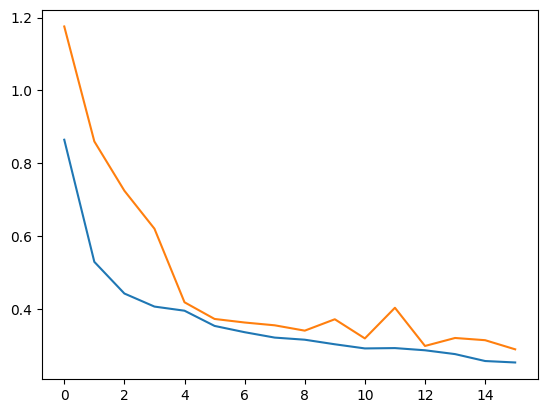

Epoch: 17
Train...


100%|██████████| 13/13 [00:00<00:00, 14.22it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 44.30it/s]


Mean IoU: 0.6105
Valid loss improved from 0.2895 to 0.2597. Saving checkpoint: ./best.pth
	Train Loss: 0.242
	 Val. Loss: 0.260



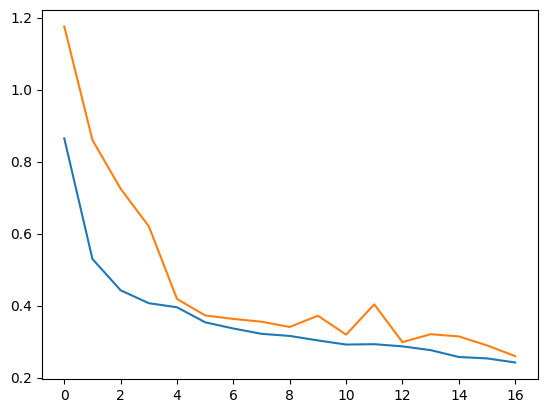

Epoch: 18
Train...


100%|██████████| 13/13 [00:00<00:00, 14.10it/s]


Valid...


100%|██████████| 13/13 [00:00<00:00, 43.30it/s]


Mean IoU: 0.6146
Valid loss improved from 0.2597 to 0.2538. Saving checkpoint: ./best.pth
	Train Loss: 0.232
	 Val. Loss: 0.254



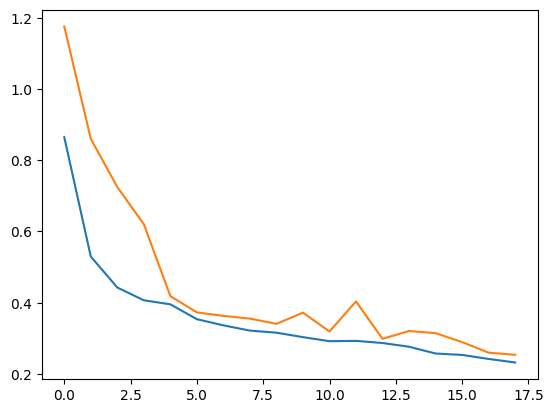

Epoch: 19
Train...


 15%|█▌        | 2/13 [00:00<00:01,  9.36it/s]


KeyboardInterrupt: 

In [26]:

import os
import time
import numpy as np
from glob import glob
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm

def train(model, loader, optimizer, loss_fn, device):
    print("Train...")
    epoch_loss = 0.0

    
    model.train()
    for x, y in tqdm(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device, threshold = 0.6):
    print("Valid...")
    epoch_loss = 0.0

    iou_arr = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            iou = iou_pytorch(y_pred, y)

            iou_arr.append(iou.cpu().numpy())
        mean_iou = np.mean(iou_arr)
        print('Mean IoU: {:.4f}'.format(mean_iou))
        epoch_loss = epoch_loss/len(loader)
        
    return epoch_loss


if __name__ == "__main__":
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    '''
    Code Unet for ----------  2 CLASSES ----------
    '''

    seeding(1234)
    """ Load dataset """
    train_x = sorted(glob("đường dẫn tới thư mục ảnh tập train/*")) # Lưu ý: Có dấu * phía cuối
    train_y = sorted(glob("đường dẫn tới thư mục label tập train/*"))
    valid_x = sorted(glob("đường dẫn tới thư mục ảnh train của tập test/*"))
    valid_y = sorted(glob("đường dẫn tới thư mục label của tập test/*"))


    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 80
    W = 160
    size = (W, H)
    batch_size = 4
    num_epochs = 30
    lr = 1e-4
    checkpoint_path = "./best.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y, W, H)
    valid_dataset = DriveDataset(valid_x, valid_y, W, H)


    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    device = torch.device('cuda') 
    model = build_unet()
    model = model.to(device)

    torch.backends.cudnn.benchmark = True # new
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    loss_train_plt = []
    loss_val_plt = []

    for epoch in range(num_epochs):
        print("Epoch:", epoch+1)
        train_loss = train(model, train_loader, optimizer, loss_fn, device)    
        valid_loss = evaluate(model, valid_loader, loss_fn, device)
        
        """ Saving the model """
        if valid_loss < best_valid_loss:
            print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

            best_valid_loss = valid_loss
            name = os.path.join(os.getcwd(), "output_" + str(epoch) + ".pth")
            torch.save(model.state_dict(), name)

        print(f'\tTrain Loss: {train_loss:.3f}\n\t Val. Loss: {valid_loss:.3f}\n')
        
        loss_train_plt.append(train_loss)
        loss_val_plt.append(valid_loss)
        plt.plot(loss_train_plt)
        plt.plot(loss_val_plt)
        plt.show(f"loss_epoch_{epoch}.png")  

Test mô hình

In [ ]:
import cv2
import numpy as np
import torch
import time

checkpoint_path = "duong dan toi file .pth"
model = build_unet().cuda()
model.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))
model.eval()

# 159, 396
img = cv2.imread("noise_lane.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (160, 80))

x = torch.from_numpy(img).cuda()
x = x.transpose(1, 2).transpose(0, 1)
x = x / 255.0
x = x.unsqueeze(0).float()
with torch.no_grad():
    pred = model(x)
    pred = torch.sigmoid(pred)
    pred = pred[0].squeeze()
    pred = (pred > 0.5).cpu().numpy()

    pred = np.array(pred, dtype=np.uint8)
    pred = pred * 255


# cv2.imwrite("pred.png", cv2.resize(pred, (160, 80)))
plt.imshow(img)
plt.show()
plt.imshow(pred)
plt.show()
